# Capstone in Mathematics Final Project
## Random Forest Regression -- Patrick Thornton
### Package imports

In [60]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.metrics import mean_squared_log_error
import time

### Open and read from data file

In [61]:
def read_data(feature):
    x_data = pd.read_csv(feature)
    x = x_data.values
    return x

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')


### Data Manipulation

In [62]:
# Rename catagory "weathersit" to be more intuitive
train.rename(columns={'weathersit':'weather'},inplace=True)
test.rename(columns={'weathersit':'weather'},inplace=True)

# Drop date column given its integer representation is noise for this model
train = train.drop(['dteday'], axis=1)
test = test.drop(['dteday'], axis=1)

# Change string type columns to catagory typed columns
train['season'] = train.season.astype('category')
train['holiday'] = train.holiday.astype('category')
train['weather'] = train.weather.astype('category')
test['season'] = test.season.astype('category')
test['holiday'] = test.holiday.astype('category')
test['weather'] = test.weather.astype('category')

# Using log to make labels more normally distributed
train['cnt'] = train['cnt'].transform(lambda x: math.log(x))
test['cnt'] = test['cnt'].transform(lambda x: math.log(x))

# Removing atemp improves RMSE by 0.007 for log normal data
# or makes estimate approximatly 0.8 value closer to true value
train = train.drop(['atemp'],axis=1)
test = test.drop(['atemp'],axis=1)

### Encode Features

In [63]:
def one_hot_encoder(df, column):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Source: Predicting bike sharing trends with Python. (2018). 
    # Medium. Retrieved 29 April 2019, from 
    # https://medium.com/@wilamelima/analysing-bike-sharing-trends-with-python-a9f574c596b9
    # 
    # Encode catagorical data to be in seperate columns
    # This avoids the algorithm treating different values with different importance
    # label is 0 -> [1 0 0 0 0 0 0 0 0]
    # label is 3 -> [0 0 0 1 0 0 0 0 0]
    #
    # Parameters:
    # df - dataframe containing data
    # column - column name to be encoded
    # 
    # Results:
    # df - updated dataframe
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)
    df = df.drop([column], axis=1)
    return df

# Copy of data to be encoded
train_ohe = train
test_ohe = test

# Columns to be encoded
cats = ['season','holiday','weather']

# Encoding columns one by one in train and test
for cat in cats:
    train_ohe = one_hot_encoder(train_ohe, cat)
    test_ohe = one_hot_encoder(test_ohe, cat)

### Split features and labels


In [64]:
y_train =  train_ohe['cnt']
X_train = train_ohe.drop(['cnt'], axis=1)
y_test =  test_ohe['cnt']
X_test = test_ohe.drop(['cnt'], axis=1)

### Execute model

In [65]:
# create RF learner (model)
myRF = RandomForestRegressor(n_estimators=100, max_features=None, random_state=0)
'''
    n_estimators: # of trees
    max_features: maximum features we will consider to split at each node
                  If “auto”, then max_features=sqrt(n_features).
                  If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
                  If “log2”, then max_features=log2(n_features).
                  If None, then max_features=n_features.
                  
'''
# fit the model to the training data
myRF.fit(X_train, y_train)
y_pred = myRF.predict(X_test)

### Model first run results

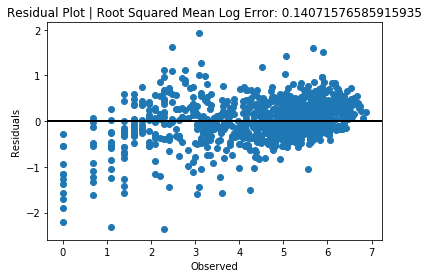

In [66]:
# Plot the residuals
residuals = y_test-y_pred
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text('Residual Plot | Root Squared Mean Log Error: ' + str(np.sqrt(mean_squared_log_error(y_test, y_pred))))
plt.show()

In [67]:
# Get feature imporance for model
feature_importances = pd.DataFrame(myRF.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("Feature Weights:\n",feature_importances)

Feature Weights:
                      importance
hr                     0.703049
temp                   0.107827
weekday                0.082589
hum                    0.035214
windspeed              0.022150
weather_Light Snow     0.016060
season_spring          0.013704
season_winter          0.006670
holiday_Yes            0.005733
weather_Mist+Cloudy    0.004142
season_summer          0.002862


## Optimize hyperparmeters

In [68]:
# Optimize the n_estimators
my_target_estimators = [100, 200, 300, 500, 1000]
for n_trees in my_target_estimators:
    myRF = RandomForestRegressor(n_estimators=n_trees, max_features=None,
                                    oob_score=True, random_state=0)
    myRF.fit(X_train, y_train)
    print('n_estimators = %d, OOB_score=%.3f' % (n_trees, myRF.oob_score_))

n_estimators = 100, OOB_score=0.895
n_estimators = 200, OOB_score=0.897
n_estimators = 300, OOB_score=0.898
n_estimators = 500, OOB_score=0.899
n_estimators = 1000, OOB_score=0.899


In [69]:
# Optimize max_features
my_max_features = [None, "sqrt", "log2"]
for max_features in my_max_features:
    myRF = RandomForestRegressor(n_estimators=500, max_features=max_features,
                                    oob_score=True, random_state=0)
    myRF.fit(X_train, y_train)
    print('max_features = %s, OOB_score=%.3f' % (max_features, myRF.oob_score_))

max_features = None, OOB_score=0.899
max_features = sqrt, OOB_score=0.862
max_features = log2, OOB_score=0.862


In [70]:
# Start function timer
start = time.time()

# create RF learner (model)
myRF = RandomForestRegressor(n_estimators=500, max_features=None, random_state=0)
'''
    n_estimators: # of trees
    max_features: maximum features we will consider to split at each node
                  If “auto”, then max_features=sqrt(n_features).
                  If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
                  If “log2”, then max_features=log2(n_features).
                  If None, then max_features=n_features.
                  
'''
# fit the model to the training data
myRF.fit(X_train, y_train)
y_pred = myRF.predict(X_test)
# print("Accuracy: ", myRF.score(X_test,y_test))

# End function timer
end = time.time()
print("Runetime to train RF model and predict test labels: ",end-start)
# Used to return labels to real number
# Removes normalizaion, not recommended for anything other than RMSE
y_num = np.asarray([int(math.exp(x)) for x in y_pred])
y_test_num = np.asarray([int(math.exp(x)) for x in y_test])

Runetime to train RF model and predict test labels:  5.240524768829346


## Accuracy

In [71]:
def RMSE(y_pred, y_test):   
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compare the difference between predicted and real values
    # using root mean square error.
    #
    # Parameters:
    # y_pred - predicted labels using p(x) (vector/list)
    # y_test - actual labels from data (vector/list)
    #
    # Return:
    # rmse - Singular value determined using root mean square error method
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    x = float(len(y_test)) # len () gives an integer value   
    rmse = np.sqrt(sum((y_test-y_pred)**2)/x)
    return rmse

In [72]:
def Pearson(y_pred, y_test):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Partial Source: Python, C., Dali, S., Hammerbacher, J., & Thoma, 
    # M. (2010). Calculating Pearson correlation and significance 
    # in Python. Stack Overflow. Retrieved 29 April 2019, from 
    # https://stackoverflow.com/questions/3949226/calculating-pearson-correlation-and-significance-in-python
    #
    # Compare the difference between predicted and real values
    # using pearson method.
    #
    # Parameters:
    # y_pred - predicted labels using p(x) (vector/list)
    # y_test - actual labels from data (vector/list)
    #
    # Return:
    # Pearson coefficient
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # Proper variable structure tests
    assert len(y_pred) == len(y_test)
    n = len(y_pred)
    assert n > 0
    
    # Finding averages of vectors using numpy.average()
    avg_pred = np.average(y_pred)
    avg_test = np.average(y_test)
    
    # Variable initialization
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    
    # Determining correlation between each point
    for idx in range(n):
        xdiff = y_pred[idx] - avg_pred
        ydiff = y_test[idx] - avg_test
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff

    return diffprod / math.sqrt(xdiff2 * ydiff2)

In [73]:
def Spearman(y_pred,y_test):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compare the difference between predicted and real values
    # using spearman correlation.
    #
    # Parameters:
    # y_pred - predicted labels using p(x) (vector/list)
    # y_test - actual labels from data (vector/list)
    #
    # Return:
    # corr - spearman correlation
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # Proper variable structure tests
    assert len(y_pred) == len(y_test)
    n = len(y_pred)
    assert n > 0
    
    # Get ranks of labels
    order_pred = y_pred.argsort()
    ranks_pred = order_pred.argsort()
    order_test = y_test.argsort()
    ranks_test = order_test.argsort()
    
    # Finding averages of vectors using numpy.average()
    avg_pred = np.average(ranks_pred)
    avg_test = np.average(ranks_test)
    
    # Variable initialization
    nom = 0 # Nominator of spearman formulation
    left_sum = 0 # Sum of rank of predicted ranks, minus mean rank
    right_sum = 0 # Sum of rank of actual ranks, minus mean rank
    
    for i in range(n):
        left = ranks_pred[i] - avg_pred
        right =  ranks_test[i] - avg_test
        nom += left*right
        left_sum += left*left
        right_sum += right*right
    
    # Final calculation for R_s spearman value
    corr = nom/(math.sqrt(left_sum)*math.sqrt(right_sum))
    
    return corr

In [74]:
def KendallTau(x,y):
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Compare the difference between predicted and real values
    # using spearman correlation.
    #
    # Parameters:
    # x - predicted labels using p(x) (vector/list)
    # y - actual labels from data (vector/list)
    #
    # Return:
    # t - Kendall Tau statistic
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    
    # Proper parameter structure tests
    assert len(x) == len(y)
    n = len(x)
    assert n > 0
    
    # Variable initialization
    p = 0 # Count of concordant values
    q = 0 # Count of discordant values
    x_ties = 0 # Count of ties in predicted values
    y_ties = 0 # Count of ties in actuaL values
    
    # Determining number of concordant, discordant, or tied values
    for i in range(n-1):
        
        # Concordant values
        if x[i] > x[i+1] and y[i] > y[i+1]:
            p += 1
        elif x[i] < x[i+1] and y[i] < y[i+1]:
            p += 1
        
        # Discordant values
        elif x[i] > x[i+1] and y[i] < y[i+1]:
            q+=1
        elif x[i] < x[i+1] and y[i] > y[i+1]:
            q+=1
            
        # Ties
        elif x[i] == x[i+1]:
            x_ties +=1
        elif y[i] == y[i+1]:
            y_ties += 1
        
        # Safty pass
        else:
            pass
    
    # Calculation of Kendall Tau statistic
    t = (p-q)/(math.sqrt(p+q+x_ties)*math.sqrt(p+q+y_ties))
    return t

### Formatting and displaying different correlation values

In [77]:
rmse = RMSE(y_num, y_test_num)
spearman_corr = Spearman(y_pred, y_test)
ken = KendallTau(y_pred, y_test)
pearson_corr = Pearson(y_pred, y_test)

print('The Root Mean Square Error of the data is %.4f' % rmse)
print('The Pearson correlation of the data is %.4f' % pearson_corr)
print('The Spearman correlation of the data is %.4f' % spearman_corr)
print('The Kendall Tau statistic of the data is %.4f' % ken)

The Root Mean Square Error of the data is 76.5793
The Pearson correlation of the data is 0.9534
The Spearman correlation of the data is 0.9413
The Kendall Tau statistic of the data is 0.7888


## Model visualization

<function matplotlib.pyplot.show(*args, **kw)>

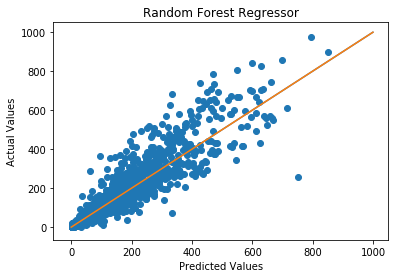

In [76]:
x = np.arange(1000)
y = x
plt.plot(x, y, '-')
plt.scatter(y_num,y_test_num)
plt.plot(x,)
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.title('Random Forest Regressor')
ax.title.set_text('Residual Plot | Root Squared Mean Log Error: ' + str(np.sqrt(mean_squared_log_error(y_test, y_pred))))
plt.show